# This script tests our Pix2Pix GAN trained `generator_120.pth` 

In [9]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image, ImageFilter
import numpy as np
import os
import glob
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from scipy.spatial.distance import jensenshannon

def conv_block(in_c, out_c, norm=True):
    layers = [nn.Conv2d(in_c, out_c, 4, 2, 1, bias=False)]
    if norm: layers.append(nn.BatchNorm2d(out_c))
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    return nn.Sequential(*layers)

def deconv_block(in_c, out_c, dropout=False):
    layers = [
        nn.ConvTranspose2d(in_c, out_c, 4, 2, 1, bias=False),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True)
    ]
    if dropout: layers.append(nn.Dropout(0.5))
    return nn.Sequential(*layers)

def denoise_image_pil(image_np):
    image_pil = Image.fromarray(image_np)
    denoised_pil = image_pil.filter(ImageFilter.MedianFilter(size=3))
    return np.array(denoised_pil)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = conv_block(3, 64, norm=False)
        self.d2 = conv_block(64, 128)
        self.d3 = conv_block(128, 256)
        self.d4 = conv_block(256, 512)
        self.d5 = conv_block(512, 512)
        self.d6 = conv_block(512, 512)
        self.d7 = conv_block(512, 512)
        self.d8 = conv_block(512, 512)
        self.u1 = deconv_block(512, 512, dropout=True)
        self.u2 = deconv_block(1024, 512, dropout=True)
        self.u3 = deconv_block(1024, 512, dropout=True)
        self.u4 = deconv_block(1024, 512)
        self.u5 = deconv_block(1024, 256)
        self.u6 = deconv_block(512, 128)
        self.u7 = deconv_block(256, 64)
        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.d1(x); d2 = self.d2(d1)
        d3 = self.d3(d2); d4 = self.d4(d3)
        d5 = self.d5(d4); d6 = self.d6(d5)
        d7 = self.d7(d6); d8 = self.d8(d7)
        u1 = self.u1(d8)
        u2 = self.u2(torch.cat([u1, d7],1))
        u3 = self.u3(torch.cat([u2, d6],1))
        u4 = self.u4(torch.cat([u3, d5],1))
        u5 = self.u5(torch.cat([u4, d4],1))
        u6 = self.u6(torch.cat([u5, d3],1))
        u7 = self.u7(torch.cat([u6, d2],1))
        return self.final(torch.cat([u7, d1],1))

## SAME AS IN app.py

/tmp/ipykernel_176/789642728.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(model_path, map_location=device))


Model loaded from /kaggle/input/generator_120_comic/pytorch/default/1/generator_120.pth


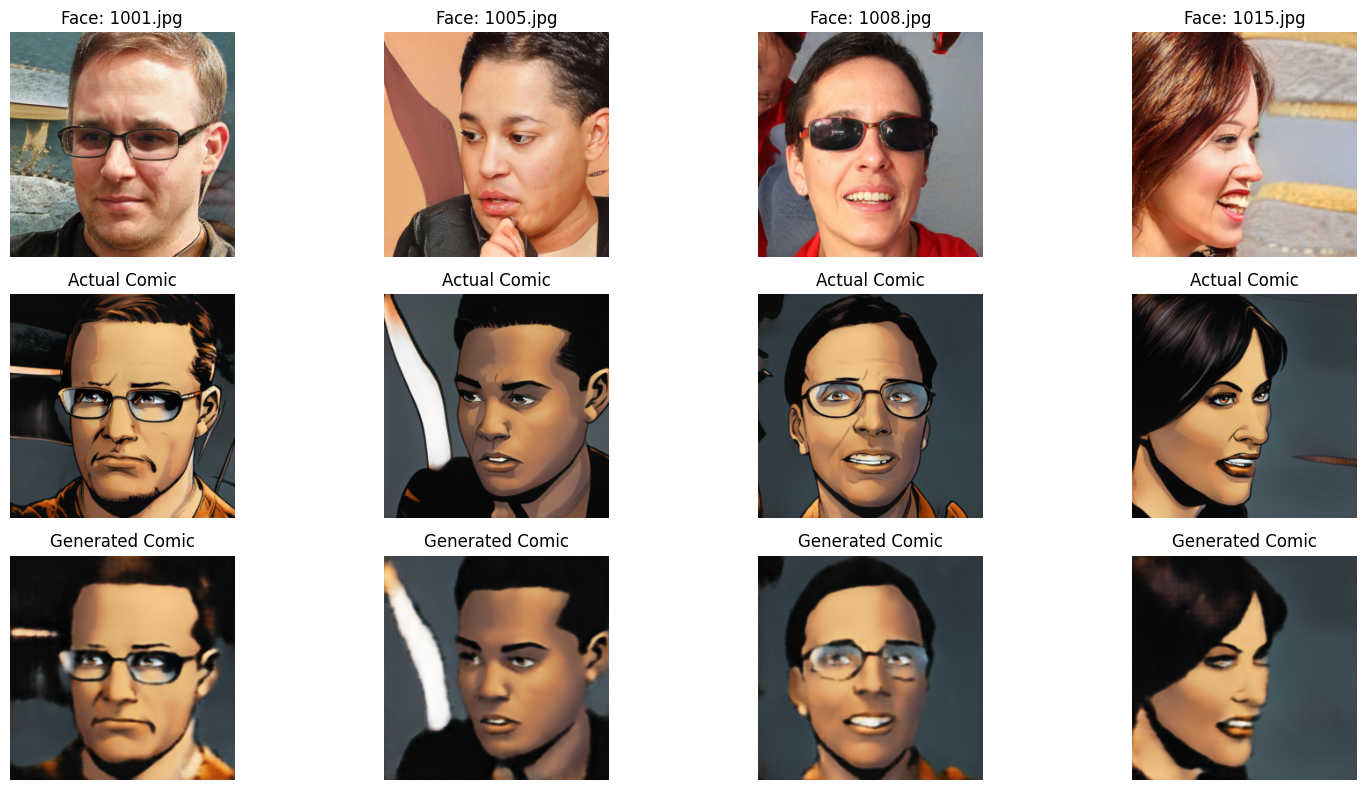

In [10]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image, ImageFilter
import numpy as np
import os
import glob
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from scipy.spatial.distance import jensenshannon


class FaceComicDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg"))[8000:10000] + 
                                 glob.glob(os.path.join(image_dir, "*.png"))[8000:10000])
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        return image, os.path.basename(img_path)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

comics_dir = "/kaggle/input/comic-faces-paired-synthetic-v2/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/comics"
faces_dir = "/kaggle/input/comic-faces-paired-synthetic-v2/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces"

comics_dataset = FaceComicDataset(comics_dir, transform)
faces_dataset = FaceComicDataset(faces_dir, transform)

comics_loader = DataLoader(comics_dataset, batch_size=4, shuffle=False)
faces_loader = DataLoader(faces_dataset, batch_size=4, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)

model_path = "/kaggle/input/generator_120_comic/pytorch/default/1/generator_120.pth"  # Update this path

if os.path.exists(model_path):
    generator.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Model loaded from {model_path}")
else:
    print(f"Model file not found at {model_path}. Please check the path.")
   
    print("Initializing with random weights for testing purposes.")

generator.eval()

def denormalize(tensor):
    return (tensor * 0.5 + 0.5).clamp(0, 1)

def test_face_to_comic():
    with torch.no_grad():
        faces_iter = iter(faces_loader)
        faces_batch, face_names = next(faces_iter)
        faces_batch = faces_batch.to(device)
        
        comics_iter = iter(comics_loader)
        comics_batch, comic_names = next(comics_iter)
        comics_batch = comics_batch.to(device)
        generated_comics = generator(faces_batch)
        
        plt.figure(figsize=(16, 8))
        for i in range(min(4, len(faces_batch))):
            # Original face
            plt.subplot(3, 4, i+1)
            plt.imshow(denormalize(faces_batch[i].cpu()).permute(1, 2, 0))
            plt.title(f"Face: {face_names[i]}")
            plt.axis('off')
            
            # Actual comic
            plt.subplot(3, 4, i+5)
            plt.imshow(denormalize(comics_batch[i].cpu()).permute(1, 2, 0))
            plt.title(f"Actual Comic")
            plt.axis('off')
            
            # Generated comic
            plt.subplot(3, 4, i+9)
            plt.imshow(denormalize(generated_comics[i].cpu()).permute(1, 2, 0))
            plt.title(f"Generated Comic")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

test_face_to_comic()



In [11]:
def calculate_simple_metrics():
    with torch.no_grad():
        faces_iter = iter(faces_loader)
        comics_iter = iter(comics_loader)
        
        faces_batch, _ = next(faces_iter)
        comics_batch, _ = next(comics_iter)
        
        faces_batch = faces_batch[:1000].to(device)
        comics_batch = comics_batch[:1000].to(device)
        
        generated_comics = generator(faces_batch)
        
        l2_dists = []
        fid_scores = []
        for i in range(len(faces_batch)):
            l2_dist = torch.norm(generated_comics[i].view(-1) - comics_batch[i].view(-1), p=2).item()
            l2_dists.append(l2_dist)
            
            gen_img = generated_comics[i].cpu().numpy()
            real_img = comics_batch[i].cpu().numpy()
            
            gen_feat = gen_img.reshape(1, -1)
            real_feat = real_img.reshape(1, -1)
            
            mu1 = np.mean(gen_feat, axis=0)
            mu2 = np.mean(real_feat, axis=0)

            feature_subset = min(1000, gen_feat.shape[1])
            indices = np.random.choice(gen_feat.shape[1], feature_subset, replace=False)
            
            sigma1 = np.cov(gen_feat[:, indices], rowvar=False) + np.eye(feature_subset) * 1e-6
            sigma2 = np.cov(real_feat[:, indices], rowvar=False) + np.eye(feature_subset) * 1e-6
            
            # Calculate FID components
            diff = mu1[indices] - mu2[indices]
            
            try:
                covmean_sqrt = sqrtm(sigma1.dot(sigma2))
                if np.iscomplexobj(covmean_sqrt):
                    covmean_sqrt = covmean_sqrt.real
                fid = np.sum(diff**2) + np.trace(sigma1 + sigma2 - 2*covmean_sqrt)
                fid_scores.append(fid)
            except:
                continue
        
        avg_l2 = sum(l2_dists) / len(l2_dists)
        avg_fid = sum(fid_scores) / len(fid_scores) if fid_scores else float('inf')
        
        # For JS distance, use a very simplified approach
        # Just calculate on the first image to avoid memory issues
        gen_flat = generated_comics[0].view(-1).cpu().numpy()
        real_flat = comics_batch[0].view(-1).cpu().numpy()
        
        # Normalize to create probability distributions
        gen_prob = (gen_flat - gen_flat.min()) / (gen_flat.max() - gen_flat.min() + 1e-8)
        real_prob = (real_flat - real_flat.min()) / (real_flat.max() - real_flat.min() + 1e-8)
        
        # Calculate JS distance on just the first few values to save memory
        sample_size = min(10000, len(gen_prob))
        js_dist = jensenshannon(gen_prob[:sample_size], real_prob[:sample_size])
        
        # Calculate mean difference as a very simple metric
        mean_diff = np.mean(np.abs(gen_img - real_img))
        
        print(f"Average L2 distance: {avg_l2:.4f}")
        print(f"JS distance (sample): {js_dist:.4f}")
        print(f"Average FID score: {avg_fid:.4f}")
        print(f"Mean pixel difference: {mean_diff:.4f}")
        
        return {
            'avg_l2': avg_l2,
            'js_dist': js_dist,
            'avg_fid': avg_fid,
            'mean_diff': mean_diff
        }

metrics = calculate_simple_metrics()


Average L2 distance: 56.8705
JS distance (sample): 0.1684
Average FID score: 17.4550
Mean pixel difference: 0.0472
